In [1]:
import numpy as np
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model

1/1 [==============================] - 2s 2s/step
Predicted: [('n01665541', 'leatherback_turtle', 0.9608966)]


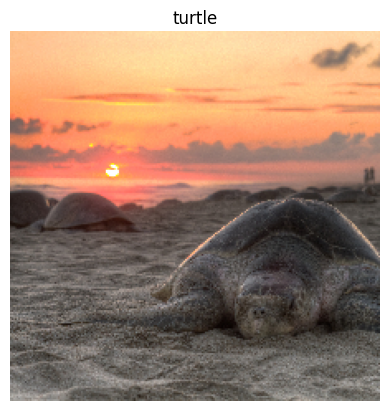

In [2]:
from matplotlib import pyplot as plt

model = ResNet50(weights='imagenet')

img_path = "..\\turtle.jpg"""
img = image.load_img(img_path, target_size=(224, 224), keep_aspect_ratio=True)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(preprocess_input(x))

preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=1)[0])
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title("turtle")
plt.show()

In [ ]:
model.summary()

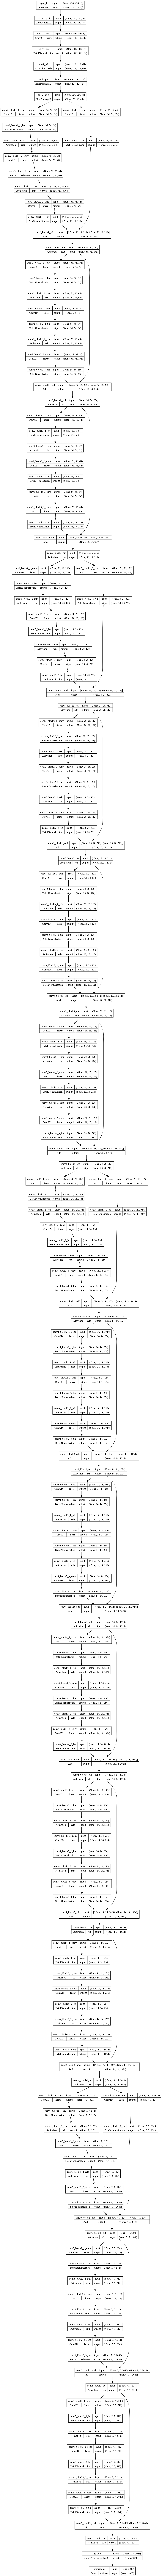

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [ ]:
model.summary()

In [ ]:
for i in range(len(model.layers)):
    print(str(i) + ":", model.get_layer(index=i))

In [21]:
from resnet50.utils import split_functional_model

head, tail = split_functional_model(model, 37)

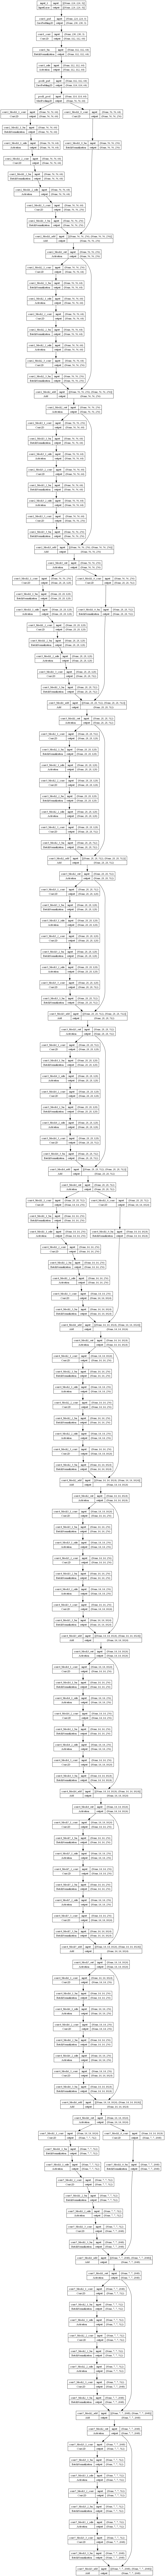

In [22]:
plot_model(head, show_layer_names=True, show_shapes=True)

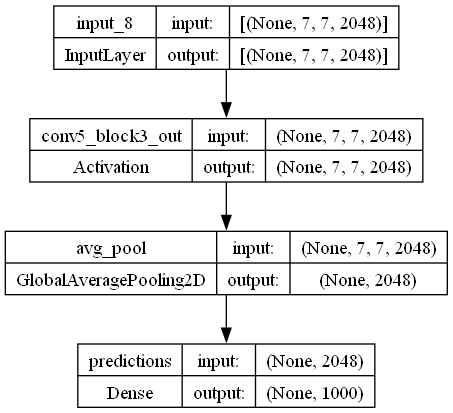

In [23]:
plot_model(tail, show_layer_names=True, show_shapes=True)

In [ ]:
inter = head.predict(x)
out = tail.predict(inter)
print('Predicted:', decode_predictions(preds, top=5)[0])
print('Predicted:', decode_predictions(out, top=5)[0])

In [ ]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 224, 224, 3)
        yield [data.astype(np.float32)]


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()

# Save the model.
with open('full_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)
input_data = tf.image.convert_image_dtype(x, dtype=tf.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Predicted:', decode_predictions(output_data, top=5)[0])

In [ ]:
plt.figure()
plt.imshow(input_data[0])
plt.axis('off')
plt.title("turtle")
plt.show()

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
test_ds = tfds.load('mnist', split=['train', 'test[:50%]'])